In [1]:
import os, re
import pickle
import numpy as np
import pandas as pd

#matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable

import matplotlib.colors as mc
from mpl_toolkits.axes_grid1 import make_axes_locatable

#scipy
from scipy import ndimage
from scipy.stats import gaussian_kde

import rioxarray
import xarray
import rasterio
import xarray as xr

## GDAL
from osgeo import gdal, osr, ogr
 
## WQ_SAT
from wq_sat import config
from wq_sat.satellites import sentinel2
from wq_sat.bathymetry import SDB
from wq_sat.utils import geo_utils, plot_utils, data_utils

## Load the model to predict

In [2]:
train_region = 'CalaMillor'
train_year = '2018'
main_path = os.path.join(config.data_path(), 'bathymetries', train_region, train_year)

In [4]:
# load the Zgreen model from disk
Zgr_file = '{}_Zgreen_model_{}.sav'.format(train_region, train_year)
Zgreen_model = pickle.load(open(os.path.join(main_path, 'models', Zgr_file), 'rb'))

# load the Zred model from disk
Zr_file = '{}_Zred_model_{}.sav'.format(train_region, train_year)
Zred_model = pickle.load(open(os.path.join(main_path, 'models', Zr_file), 'rb'))

## Test and predict pSDB

In [5]:
test_region = 'CalaMillor'
test_year = '2019'
main_path = os.path.join(config.data_path(), 'bathymetries', test_region, test_year)

In [6]:
save_plots = False
test_path = os.path.join(config.data_path(), 'bathymetries', 'tests', 'train_{}{}_test_{}{}'.format(train_region, train_year, test_region, test_year))
if not os.path.isdir(test_path):
    os.makedirs(test_path)
    os.makedirs(os.path.join(test_path, 'plots'))

### In-situ bathymetry

Num of bands: 1
Shape: (190, 77)
CRS: EPSG:32631
{'N': 39.603706288152, 'W': 3.3843306531157413, 'S': 39.58664735160755, 'E': 3.39308671999637}


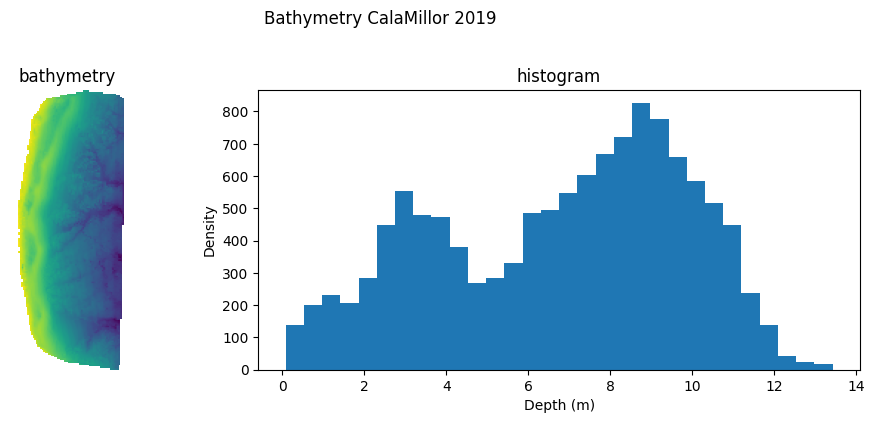

In [8]:
## In-situ bathymetry
file = '{}_Insitu_bathymetry_EPSG32631_{}.tif'.format(test_region, test_year)
bathymetry, BBox, crs = geo_utils.load_geotiff(os.path.join(main_path, file))
mx = np.ma.masked_invalid(bathymetry)

## transform coordinates
new_ul = geo_utils.transform_coordinates(BBox[0], inputEPSG=crs, outputEPSG=4326)
new_lr = geo_utils.transform_coordinates(BBox[1], inputEPSG=crs, outputEPSG=4326)

# ROI
roi_coord = {'N': new_ul[0], 'W': new_ul[1], 'S': new_lr[0], 'E': new_lr[1]}
print(roi_coord)

# plot it
fig=plt.figure(figsize=(12,8))

ax1 = plt.subplot2grid((2,3),(0,0))
ax1.imshow(bathymetry)
ax1.set_title('bathymetry')
ax1.axis('off')

ax2 = plt.subplot2grid((2,3),(0,1), colspan=3)
ax2.hist((-bathymetry).flatten(), bins='auto')
ax2.set_title('histogram')
ax2.set_xlabel('Depth (m)')
ax2.set_ylabel('Density')

fig.suptitle('Bathymetry {} {}'.format(test_region, test_year))
plt.show()

## Composite Approach

In [9]:
tiles = config.get_tiles(test_region, test_year)
Zgr_max, Zr_max, Rs492, Rs559, Rs704, chl, coord = SDB.composite_approach(tiles, roi_coord)

Zgr_max[mx.mask] = np.nan
Zr_max[mx.mask] = np.nan
Rs492[mx.mask] = np.nan
Rs559[mx.mask] = np.nan
Rs704[mx.mask] = np.nan
chl[mx.mask] = np.nan

Loading /home/wqsat_data/Sentinel-2/ACOLITE/S2A_MSIL1C_20190920T104021_N0208_R008_T31SED_20190920T111121
Selected pixel region: xmin=3301, ymin=1619, xmax=3377, ymax=1808:
Image size: width=77 x height=190
Loading /home/wqsat_data/Sentinel-2/ACOLITE/S2A_MSIL1C_20190920T104021_N0208_R008_T31SED_20190920T111121
Selected pixel region: xmin=3301, ymin=1619, xmax=3377, ymax=1808:
Image size: width=77 x height=190
Loading /home/wqsat_data/Sentinel-2/ACOLITE/S2A_MSIL1C_20190930T104021_N0208_R008_T31SED_20190930T125317
Selected pixel region: xmin=3301, ymin=1619, xmax=3377, ymax=1808:
Image size: width=77 x height=190
Loading /home/wqsat_data/Sentinel-2/ACOLITE/S2A_MSIL1C_20191007T103021_N0208_R108_T31SED_20191007T124441
Selected pixel region: xmin=3301, ymin=1619, xmax=3377, ymax=1808:
Image size: width=77 x height=190
Loading /home/wqsat_data/Sentinel-2/ACOLITE/S2A_MSIL1C_20191027T103131_N0208_R108_T31SED_20191027T105507
Selected pixel region: xmin=3301, ymin=1619, xmax=3377, ymax=1808:
Imag

/home/wq_sat/wq_sat/bathymetry/SDB.py:39: RuntimeWarning: All-NaN slice encountered
  Zgr_max = np.nanmax(Zgreen, axis=2)
/home/wq_sat/wq_sat/bathymetry/SDB.py:43: RuntimeWarning: All-NaN slice encountered
  Zr_max = np.nanmax(Zred, axis=2)


## pSDBgreen test

/tmp/ipykernel_84/244254742.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  axs[0].plot([0,16], [0,16], 'k-', c='r', alpha=0.75, zorder=0)


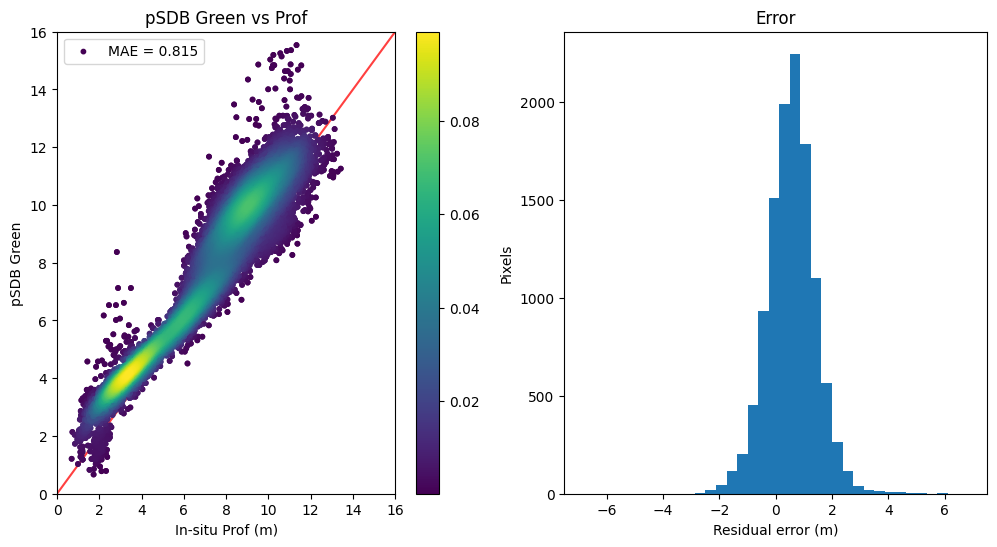

In [10]:
pSDBgreen = Zgreen_model(Zgr_max)
pSDBgr_diff = pSDBgreen - (-bathymetry)

mx = np.ma.masked_invalid(pSDBgr_diff)
diff = pSDBgr_diff[~mx.mask]

# Calculate the point density
x = -bathymetry[~mx.mask]
y = pSDBgreen[~mx.mask]
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

MAE = np.nanmean(np.abs(diff))
RMSE = np.sqrt(np.nanmean(diff**2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(x, y, c=z, s=10, label=f'MAE = {MAE:.3f}')
ax_ = axs[0].scatter(x, y, c=z, s=10)
plt.colorbar(ax_)
axs[0].plot([0,16], [0,16], 'k-', c='r', alpha=0.75, zorder=0)
axs[0].set_xlabel("In-situ Prof (m)")
axs[0].set_xlim(0,16)
axs[0].set_ylabel("pSDB Green")
axs[0].set_ylim(0,16)
axs[0].legend()
axs[0].set_title("pSDB Green vs Prof")

axs[1].hist(pSDBgr_diff.flatten(), bins=50)
axs[1].set_xlim(-7.5,7.5)
axs[1].set_xlabel("Residual error (m)")
axs[1].set_ylabel("Pixels")
axs[1].set_title("Error")

# Save the full figure...
if save_plots:
    file = 'Zgreen_adjust_residual_train_{}{}_test_{}{}.png'.format(train_region, train_year, test_region, test_year)
    fig.savefig(os.path.join(test_path, 'plots', file))

## pSDBred test

/tmp/ipykernel_84/4230775531.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  axs[0].plot([0,16], [0,16], 'k-', c='r', alpha=0.75, zorder=0)


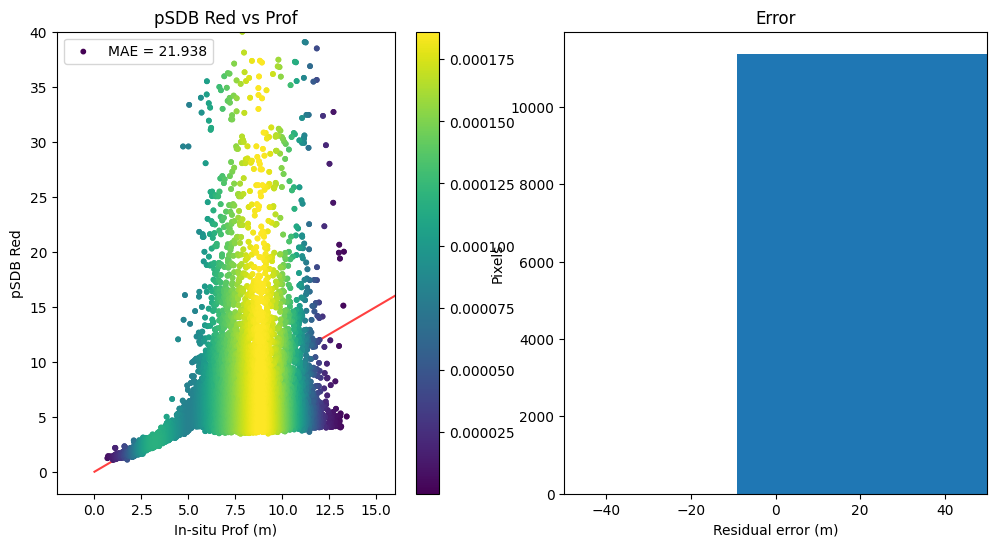

In [11]:
pSDBred = Zred_model(Zr_max)
pSDBred_diff = pSDBred - (-bathymetry)

mx = np.ma.masked_invalid(pSDBred_diff)
diffred = pSDBred_diff[~mx.mask]

# Calculate the point density
x = -bathymetry[~mx.mask]
y = pSDBred[~mx.mask]
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

MAE = np.mean(np.abs(diffred))
RMSE = np.sqrt(np.nanmean(diffred**2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(x, y, c=z, s=10, label=f'MAE = {MAE:.3f}')
ax_ = axs[0].scatter(x, y, c=z, s=10)
plt.colorbar(ax_)
axs[0].plot([0,16], [0,16], 'k-', c='r', alpha=0.75, zorder=0)
axs[0].set_xlabel("In-situ Prof (m)")
axs[0].set_xlim(-2,16)
axs[0].set_ylabel("pSDB Red")
axs[0].set_ylim(-2,40)
axs[0].legend()
axs[0].set_title("pSDB Red vs Prof")

axs[1].hist(pSDBred_diff.flatten(), bins=2000)
axs[1].set_xlim(-50,50)
axs[1].set_xlabel("Residual error (m)")
axs[1].set_ylabel("Pixels")
axs[1].set_title("Error")

# Save the full figure...
if save_plots:
    file = 'Zred_adjust_residual_train_{}{}_test_{}{}.png'.format(train_region, train_year, test_region, test_year)
    fig.savefig(os.path.join(test_path, 'plots', file))

## Switching model

In [12]:
Switching_SDB = SDB.switching_model(pSDBgreen, pSDBred)

/tmp/ipykernel_84/1790892700.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  axs[0].plot([0,20], [0,20], 'k-', c='r', alpha=0.75, zorder=0)


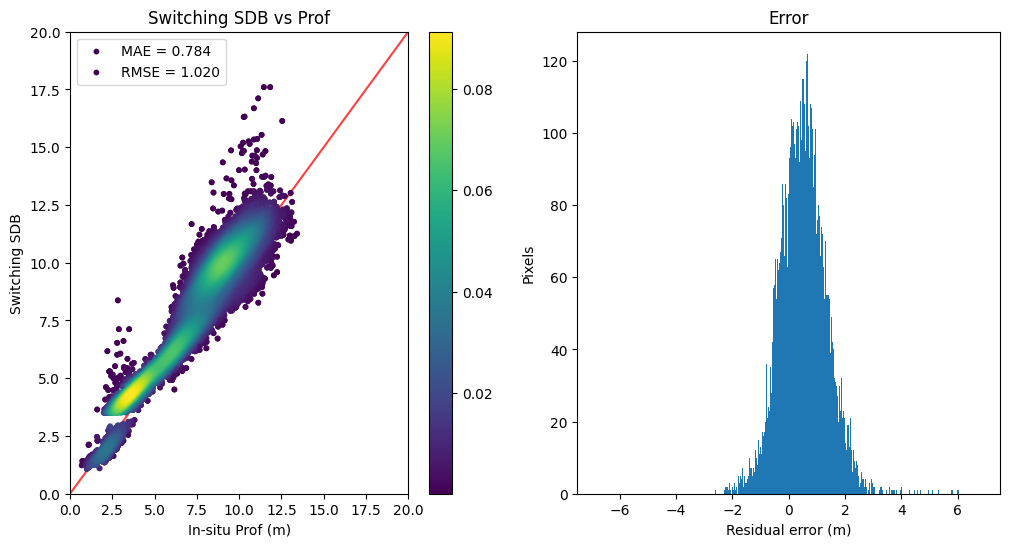

In [13]:
SDB_diff = Switching_SDB - (-bathymetry)

mx = np.ma.masked_invalid(SDB_diff)
diff = SDB_diff[~mx.mask]

# Calculate the point density
x = -bathymetry[~mx.mask]
y = Switching_SDB[~mx.mask]
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

MAE = np.mean(np.abs(diff))
RMSE = np.sqrt(np.nanmean(diff**2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(x, y, c=z, s=10, label=f'MAE = {MAE:.3f}')
ax_ = axs[0].scatter(x, y, c=z, s=10, label=f'RMSE = {RMSE:.3f}')
plt.colorbar(ax_)
axs[0].plot([0,20], [0,20], 'k-', c='r', alpha=0.75, zorder=0)
axs[0].set_xlabel("In-situ Prof (m)")
axs[0].set_xlim(-0,20)
axs[0].set_ylabel("Switching SDB")
axs[0].set_ylim(-0,20)
axs[0].legend()
axs[0].set_title("Switching SDB vs Prof")

axs[1].hist(SDB_diff.flatten(), bins=1000)
axs[1].set_xlim(-7.5,7.5)
axs[1].set_xlabel("Residual error (m)")
axs[1].set_ylabel("Pixels")
axs[1].set_title("Error")

# Save the full figure...
if save_plots:
    file = 'Switching_adjust_residual_train_{}{}_test_{}{}.png'.format(train_region, train_year, test_region, test_year)
    fig.savefig(os.path.join(test_path, 'plots', file))

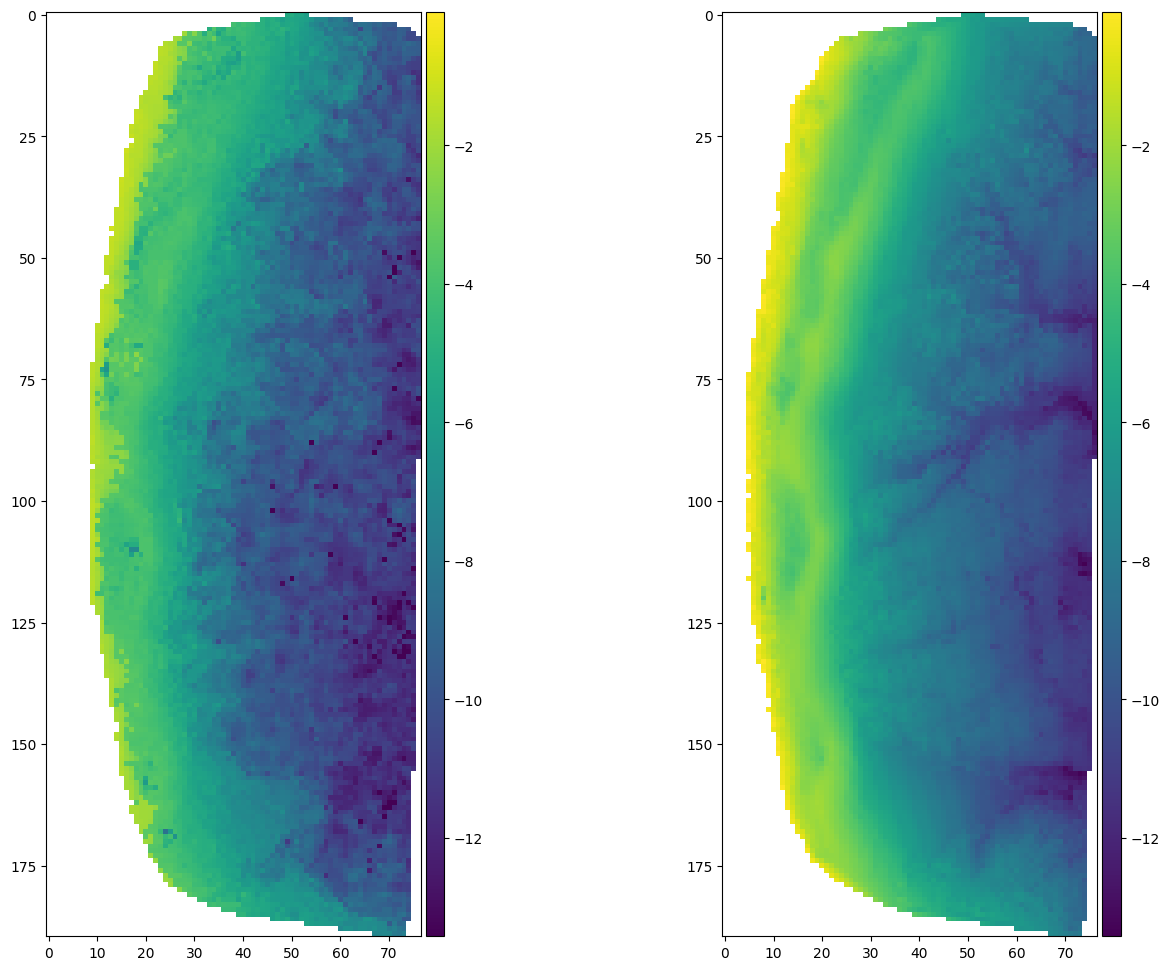

In [14]:
fig = plt.figure(figsize=(16, 12))

sdb_min = np.nanmin(bathymetry)
sdb_max = np.nanmax(bathymetry)

ax1 = fig.add_subplot(121)
im1 = ax1.imshow(-Switching_SDB, interpolation='nearest', cmap='viridis', vmin=sdb_min, vmax=sdb_max)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(bathymetry, interpolation='nearest', cmap='viridis', vmin=sdb_min, vmax=sdb_max)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical');

In [16]:
# SDB geotiff
file = 'Switching_SDB_train_{}{}_test_{}{}.tif'.format(train_region, train_year, test_region, test_year)
geo_utils.save_gdal(os.path.join(test_path, file), 
                     np.expand_dims(Switching_SDB, axis=-1), 
                     ['Switching_SDB'], 
                     coord['geotransform'], 
                     coord['geoprojection'])

## ODW

In [17]:
ODW_SDB = SDB.odw_model(Switching_SDB, Rs492, Rs559, Rs704)

/tmp/ipykernel_84/3981719577.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  axs[0].plot([0,18], [0,18], 'k-', c='r', alpha=0.75, zorder=0)


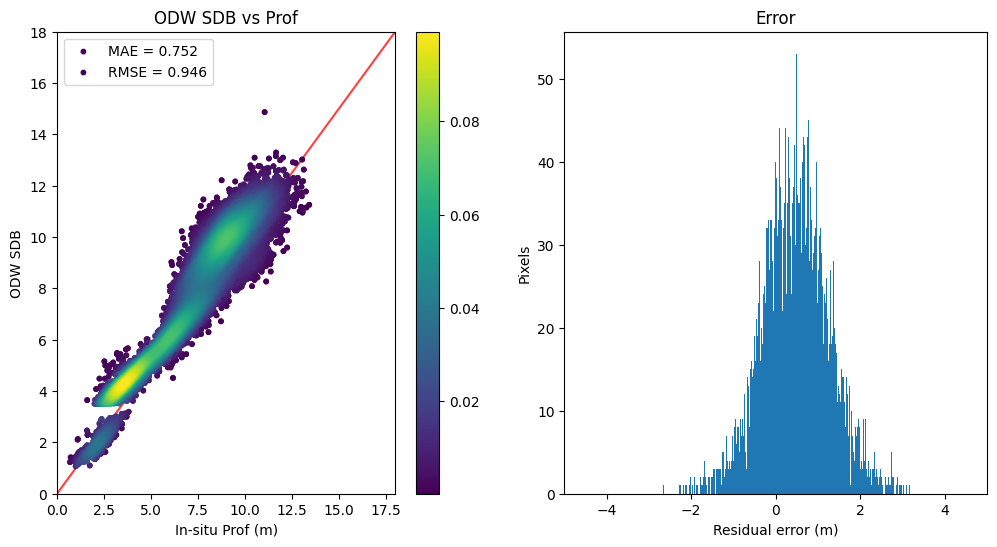

In [18]:
SDB_diff = ODW_SDB - (-bathymetry)

mx = np.ma.masked_invalid(SDB_diff)
diff = SDB_diff[~mx.mask]

# Calculate the point density
x = -bathymetry[~mx.mask]
y = ODW_SDB[~mx.mask]
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

MAE = np.mean(np.abs(diff))
RMSE = np.sqrt(np.nanmean(diff**2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(x, y, c=z, s=10, label=f'MAE = {MAE:.3f}')
ax_ = axs[0].scatter(x, y, c=z, s=10, label=f'RMSE = {RMSE:.3f}')
plt.colorbar(ax_)
axs[0].plot([0,18], [0,18], 'k-', c='r', alpha=0.75, zorder=0)
axs[0].set_xlabel("In-situ Prof (m)")
axs[0].set_xlim(0,18)
axs[0].set_ylabel("ODW SDB")
axs[0].set_ylim(0,18)
axs[0].legend()
axs[0].set_title("ODW SDB vs Prof")

axs[1].hist(SDB_diff.flatten(), bins=1000)
axs[1].set_xlim(-5,5)
axs[1].set_xlabel("Residual error (m)")
axs[1].set_ylabel("Pixels")
axs[1].set_title("Error")

# Save the full figure...
if save_plots:
    file = 'ODW_adjust_residual_train_{}{}_test_{}{}.png'.format(train_region, train_year, test_region, test_year)
    fig.savefig(os.path.join(test_path, 'plots', file))

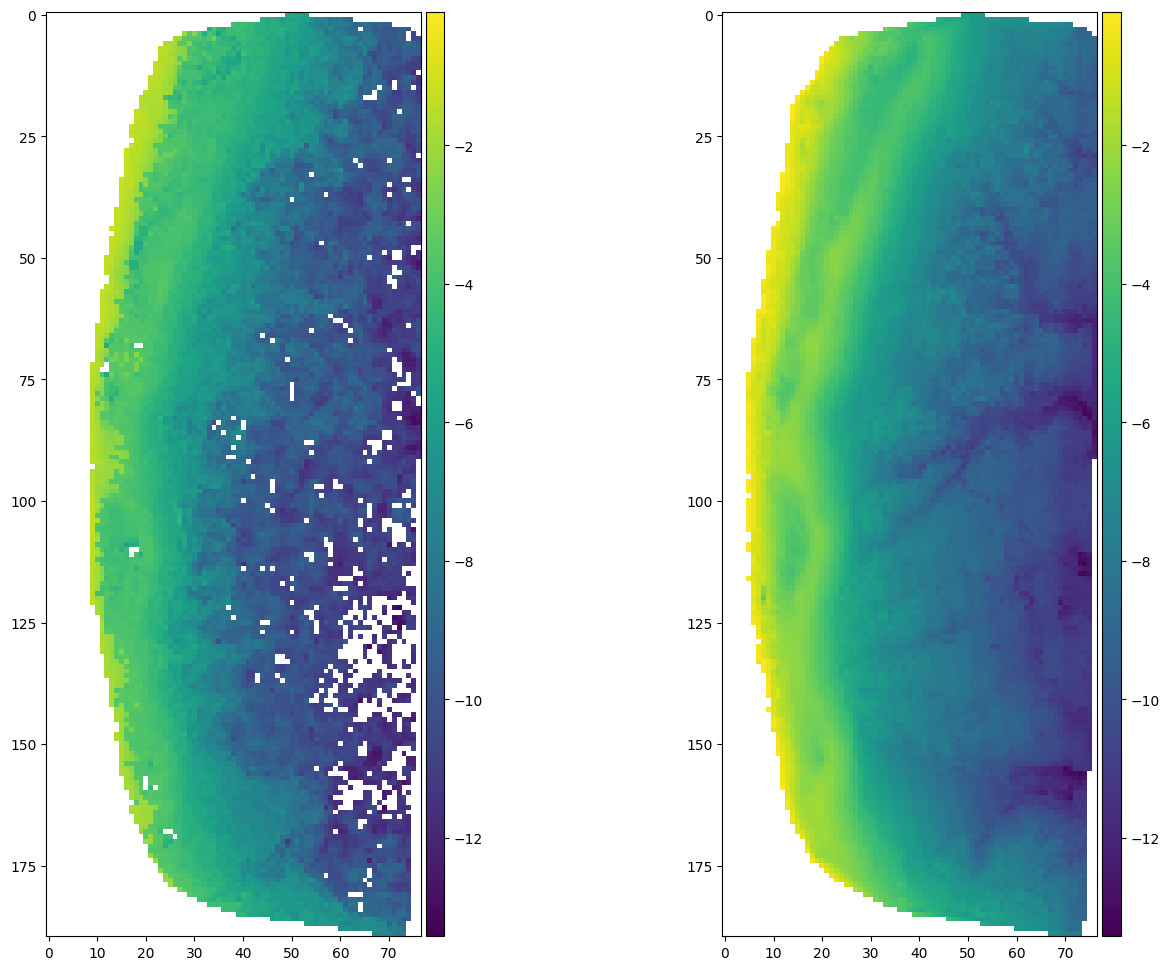

In [19]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(16, 12))

sdb_min = np.nanmin(bathymetry)
sdb_max = np.nanmax(bathymetry)

ax1 = fig.add_subplot(121)
im1 = ax1.imshow(-ODW_SDB, interpolation='nearest', cmap='viridis', vmin=sdb_min, vmax=sdb_max)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(bathymetry, interpolation='nearest', cmap='viridis', vmin=sdb_min, vmax=sdb_max)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical');

In [21]:
# SDB geotiff
file = 'ODW_SDB_train_{}{}_test_{}{}.tif'.format(train_region, train_year, test_region, test_year)
geo_utils.save_gdal(os.path.join(test_path, file), 
                     np.expand_dims(ODW_SDB, axis=-1), 
                     ['ODW_SDB'], 
                     coord['geotransform'], 
                     coord['geoprojection'])

## interpolation

In [22]:
ODW_interpolation = data_utils.interpolation2d(ODW_SDB)

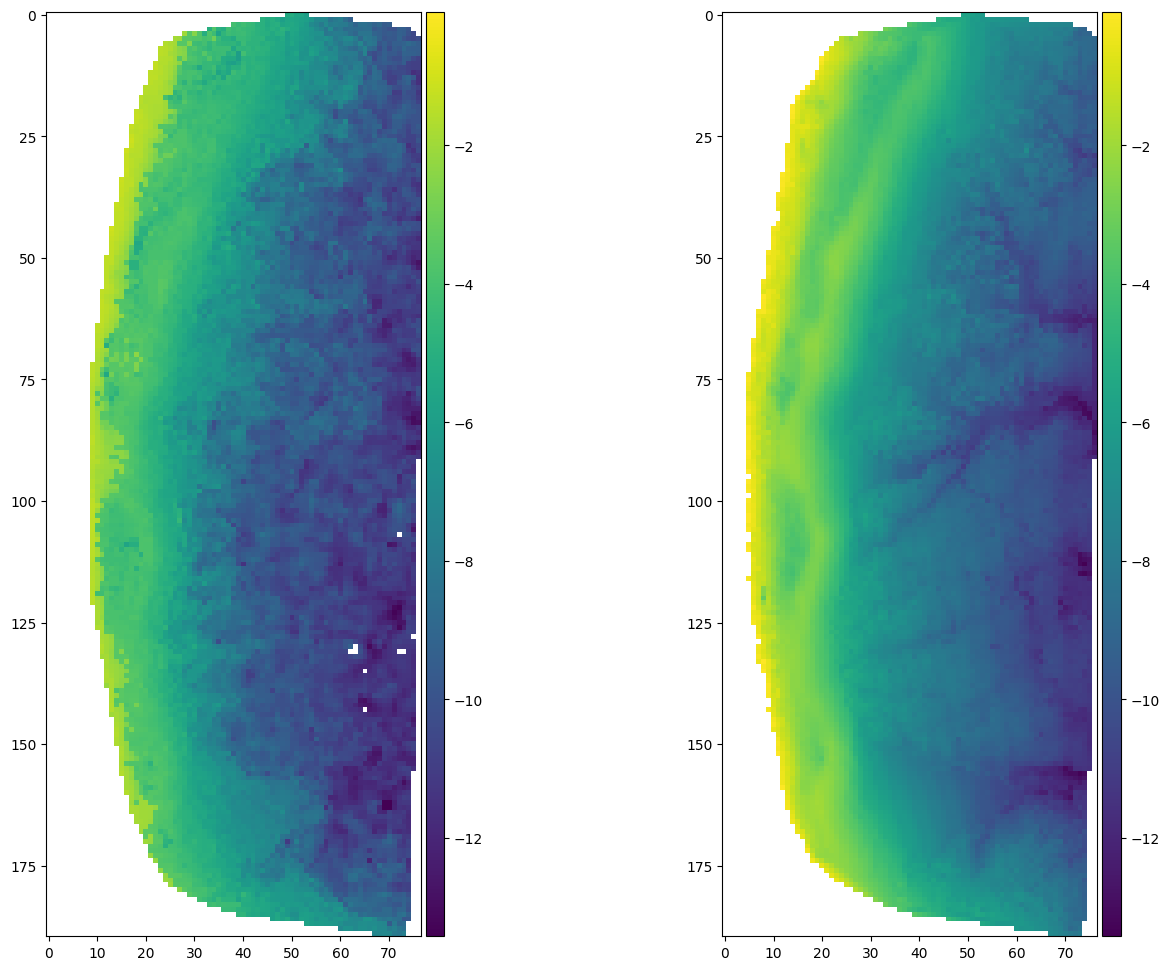

In [23]:
fig = plt.figure(figsize=(16, 12))

sdb_min = np.nanmin(bathymetry)
sdb_max = np.nanmax(bathymetry)

ax1 = fig.add_subplot(121)
im1 = ax1.imshow(-ODW_interpolation, interpolation='nearest', cmap='viridis', vmin=sdb_min, vmax=sdb_max)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(bathymetry, interpolation='nearest', cmap='viridis', vmin=sdb_min, vmax=sdb_max)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical');